In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
cleaned_test_df = pd.read_csv('/Users/honyaozhi/Downloads/cleaned_test.txt')
cleaned_train_df = pd.read_csv('/Users/honyaozhi/Downloads/cleaned_train.txt')

In [23]:
from sklearn.preprocessing import LabelEncoder
# Calculate time difference (time_diff)

# Ensure datetime column exists and is datetime type
if 'datetime' not in cleaned_train_df.columns:
    cleaned_train_df['datetime'] = pd.to_datetime(cleaned_train_df['time'], unit='ns')
else:
    cleaned_train_df['datetime'] = pd.to_datetime(cleaned_train_df['datetime'])
    # convert datetime columns in train and test to pandas datetime type

if 'datetime' not in cleaned_test_df.columns:
    cleaned_test_df['datetime'] = pd.to_datetime(cleaned_test_df['time'], unit='ns')
else:
    cleaned_test_df['datetime'] = pd.to_datetime(cleaned_test_df['datetime'])


# Calculate time difference per bidder in seconds
cleaned_train_df['time_diff'] = cleaned_train_df.groupby('bidder_id')['datetime'].diff().dt.total_seconds()
cleaned_test_df['time_diff'] = cleaned_test_df.groupby('bidder_id')['datetime'].diff().dt.total_seconds()

# Fill NaN (first bid per bidder) with 0
cleaned_train_df['time_diff'] = cleaned_train_df['time_diff'].fillna(0)
cleaned_test_df['time_diff'] = cleaned_test_df['time_diff'].fillna(0)

In [24]:
print(cleaned_train_df.head())

                               bidder_id  \
0  001068c415025a009fee375a12cff4fcnht8y   
1  0030a2dd87ad2733e0873062e4f83954mkj86   
2  00a0517965f18610417ee784a05f494d4dw6e   
3  00a0517965f18610417ee784a05f494d4dw6e   
4  00a0517965f18610417ee784a05f494d4dw6e   

                         payment_account  \
0  a3d2de7675556553a5f08e4c88d2c228iiasc   
1  a3d2de7675556553a5f08e4c88d2c228jem8t   
2  52743ba515e9c1279ac76e19f00c0b001p3pm   
3  52743ba515e9c1279ac76e19f00c0b001p3pm   
4  52743ba515e9c1279ac76e19f00c0b001p3pm   

                                 address  outcome     bid_id auction  \
0  a3d2de7675556553a5f08e4c88d2c2282aj35      0.0  7179832.0   4ifac   
1  f3bc67b04b43c3cebd1db5ed4941874c9br67      0.0  6805028.0   obbny   
2  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2501797.0   l3o6q   
3  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2724778.0   du967   
4  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2742648.0   wx3kf   

       merchandise    device         

In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from scipy.stats import entropy

def add_behavioral_features(df):
    # Cumulative bids per auction per bidder
    df['bids_per_auction'] = df.groupby(['bidder_id', 'auction']).cumcount() + 1

    # Total bids per bidder
    df['total_bids_per_bidder'] = df['bidder_id'].map(df['bidder_id'].value_counts())

    # Number of unique auctions per bidder
    df['num_unique_auctions_per_bidder'] = df['bidder_id'].map(
        df.groupby('bidder_id')['auction'].nunique()
    )

    return df

cleaned_train_df = add_behavioral_features(cleaned_train_df)
cleaned_test_df = add_behavioral_features(cleaned_test_df)

# Final list of numerical features for scaling
numerical_cols = [
    'bids_per_auction', 'total_bids_per_bidder', 'num_unique_auctions_per_bidder',
]

# Normalize all numerical features
scaler = MinMaxScaler()
cleaned_train_df[numerical_cols] = scaler.fit_transform(cleaned_train_df[numerical_cols])
cleaned_test_df[numerical_cols] = scaler.transform(cleaned_test_df[numerical_cols])

In [26]:
print(cleaned_train_df.head())

                               bidder_id  \
0  001068c415025a009fee375a12cff4fcnht8y   
1  0030a2dd87ad2733e0873062e4f83954mkj86   
2  00a0517965f18610417ee784a05f494d4dw6e   
3  00a0517965f18610417ee784a05f494d4dw6e   
4  00a0517965f18610417ee784a05f494d4dw6e   

                         payment_account  \
0  a3d2de7675556553a5f08e4c88d2c228iiasc   
1  a3d2de7675556553a5f08e4c88d2c228jem8t   
2  52743ba515e9c1279ac76e19f00c0b001p3pm   
3  52743ba515e9c1279ac76e19f00c0b001p3pm   
4  52743ba515e9c1279ac76e19f00c0b001p3pm   

                                 address  outcome     bid_id auction  \
0  a3d2de7675556553a5f08e4c88d2c2282aj35      0.0  7179832.0   4ifac   
1  f3bc67b04b43c3cebd1db5ed4941874c9br67      0.0  6805028.0   obbny   
2  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2501797.0   l3o6q   
3  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2724778.0   du967   
4  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2742648.0   wx3kf   

       merchandise    device         

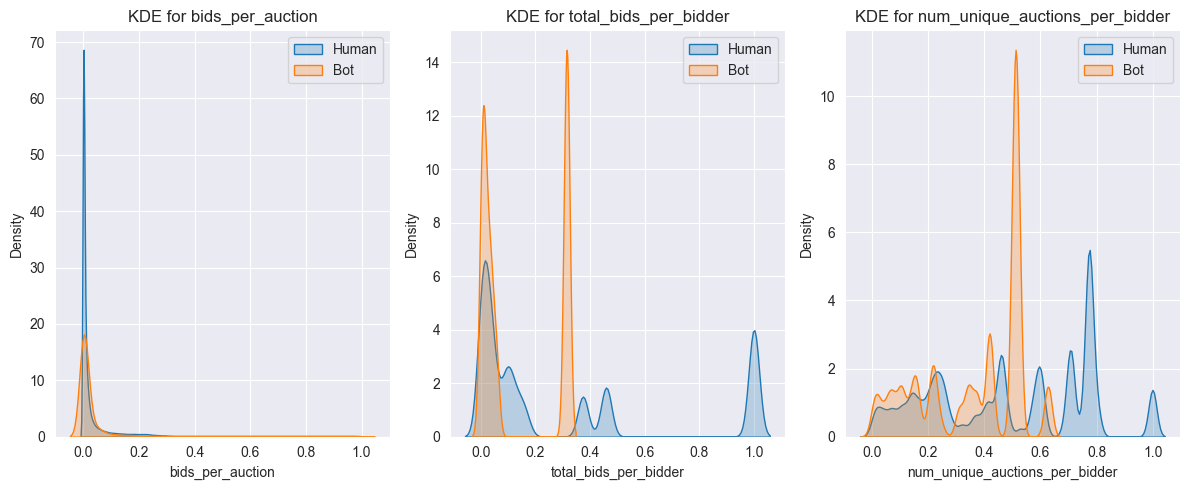

In [27]:
# Feature importance analysis for numerical feature

import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_kde_features(df, feature_list, label_col='outcome', cols=3, figsize=(12, 5)):
    num_features = len(feature_list)
    rows = math.ceil(num_features / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(feature_list):
        sns.kdeplot(data=df[df[label_col] == 0], x=feature, label='Human', fill=True, common_norm=False, ax=axes[i])
        sns.kdeplot(data=df[df[label_col] == 1], x=feature, label='Bot', fill=True, common_norm=False, ax=axes[i])
        axes[i].set_title(f'KDE for {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')
        axes[i].legend()
        axes[i].grid(True)

    # Turn off any extra axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_kde_features(cleaned_train_df, numerical_cols, label_col='outcome')

In [28]:
# Encode categorical features

categorical_features = ['device', 'merchandise', 'country', 'auction']

# Combine train and test categorical columns for consistent label encoding
combined_cat_data = pd.concat([cleaned_train_df[categorical_features], cleaned_test_df[categorical_features]], axis=0)

label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(combined_cat_data[feature].astype(str)) # Fit on combined data to cover all categories to avoid unseen categories in test set

    # Transform train and test sets
    cleaned_train_df[feature] = le.transform(cleaned_train_df[feature].astype(str))
    cleaned_test_df[feature] = le.transform(cleaned_test_df[feature].astype(str))

    # Store encoder
    label_encoders[feature] = le

    print(f"\nEncoded '{feature}' feature - number of classes: {len(le.classes_)}")


Encoded 'device' feature - number of classes: 7352

Encoded 'merchandise' feature - number of classes: 11

Encoded 'country' feature - number of classes: 200

Encoded 'auction' feature - number of classes: 15052


In [29]:
print(cleaned_train_df.head())

                               bidder_id  \
0  001068c415025a009fee375a12cff4fcnht8y   
1  0030a2dd87ad2733e0873062e4f83954mkj86   
2  00a0517965f18610417ee784a05f494d4dw6e   
3  00a0517965f18610417ee784a05f494d4dw6e   
4  00a0517965f18610417ee784a05f494d4dw6e   

                         payment_account  \
0  a3d2de7675556553a5f08e4c88d2c228iiasc   
1  a3d2de7675556553a5f08e4c88d2c228jem8t   
2  52743ba515e9c1279ac76e19f00c0b001p3pm   
3  52743ba515e9c1279ac76e19f00c0b001p3pm   
4  52743ba515e9c1279ac76e19f00c0b001p3pm   

                                 address  outcome     bid_id  auction  \
0  a3d2de7675556553a5f08e4c88d2c2282aj35      0.0  7179832.0     1817   
1  f3bc67b04b43c3cebd1db5ed4941874c9br67      0.0  6805028.0    10222   
2  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2501797.0     8884   
3  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2724778.0     5764   
4  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2742648.0    13807   

   merchandise  device         

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Reshape to 2D array for scaler input
train_time_diff = cleaned_train_df['time_diff'].values.reshape(-1, 1)
test_time_diff = cleaned_test_df['time_diff'].values.reshape(-1, 1)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data only to avoid data leakage (computation of mean & standard deviation)
scaler.fit(train_time_diff)

# Transform both train and test using fitted scaler (applies the transformation using the previously learned statistics)
train_time_diff_scaled = scaler.transform(train_time_diff)
test_time_diff_scaled = scaler.transform(test_time_diff)

# Add new scaled column to preserve original
cleaned_train_df['time_diff_scaled'] = train_time_diff_scaled
cleaned_test_df['time_diff_scaled'] = test_time_diff_scaled

# Print scaler info
print(f"Scaler mean (from train time_diff): {scaler.mean_[0]:.6f}")
print(f"Scaler variance: {scaler.var_[0]:.6f}")
print(f"Scaler scale (std dev): {scaler.scale_[0]:.6f}")

Scaler mean (from train time_diff): 20.333305
Scaler variance: 689488.003872
Scaler scale (std dev): 830.354144


In [31]:
# Define parameters
sequence_length = 100
feature_cols = ['device', 'merchandise', 'country', 'auction', 'time_diff_scaled',
                'bids_per_auction', 'total_bids_per_bidder', 'num_unique_auctions_per_bidder']

def create_sequences(df, feature_columns=feature_cols, seq_length=sequence_length):
    sequences = []
    bidder_ids = []

    grouped = df.groupby('bidder_id')

    for bidder, group in grouped:
        group = group.sort_values('datetime')  # ensure sorted

        features = group[feature_columns].values

        for start in range(0, len(features), seq_length):
            seq = features[start:start + seq_length]

            if len(seq) < seq_length:
                pad_width = seq_length - len(seq)
                seq = np.pad(seq, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)

            sequences.append(seq)
            bidder_ids.append(bidder)

    return np.array(sequences), bidder_ids

# Create sequences for training and test
X_train_ori, train_bidder_ids = create_sequences(cleaned_train_df) # labelled
X_test_submit, submit_bidder_ids = create_sequences(cleaned_test_df) #unlabelled and believes is for submission

# Get y_train from outcome labels (cleaned_train.csv contains outcome column)
labels_df = cleaned_train_df[['bidder_id', 'outcome']].drop_duplicates().set_index('bidder_id')
# Since each bidder may appear multiple times (because each bidder can place many bids), this keeps only one row per bidder, avoiding duplicated entries.

y_train_ori = np.array([labels_df.loc[bidder_id]['outcome'] for bidder_id in train_bidder_ids])
# Matched labels from cleaned_train.csv using bidder_id


1DCNN + Class Weight

In [32]:
from sklearn.utils import class_weight
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_ori),
    y=y_train_ori
)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))
print("Computed class weights:", class_weights_dict)

Computed class weights: {0: np.float64(0.57452008848926), 1: np.float64(3.854800095762509)}


In [33]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Split into training and test sets (keep stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_ori, y_train_ori, test_size=0.2, shuffle=True, random_state=42, stratify=y_train_ori
)

# Build the 1D CNN model with Dropout and L2 Regularization
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(100, 8)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile with a slightly lower learning rate
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00025)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks — EarlyStopping and ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6
)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate on test set
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")


/Users/honyaozhi/PycharmProjects/aataembedding/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 98, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 98, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 47, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       188,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,617 (842.25 KB)

 Trainable params: 215,233 (840.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5316 - loss: 1.0908 - val_accuracy: 0.8108 - val_loss: 0.7845 - learning_rate: 2.5000e-04
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6598 - loss: 0.8367 - val_accuracy: 0.7229 - val_loss: 0.8190 - learning_rate: 2.5000e-04
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6920 - loss: 0.7964 - val_accuracy: 0.7710 - val_loss: 0.7651 - learning_rate: 2.5000e-04
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7284 - loss: 0.7538 - val_accuracy: 0.7873 - val_loss: 0.7362 - learning_rate: 2.5000e-04
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7722 - loss: 0.7116 - val_accuracy: 0.7512 - val_loss: 0.7618 - learning_rate: 2.5000e-04
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7900 - loss: 0.6816 - val_accuracy: 0.7747 - val_loss: 0.7304 - learning_rate: 2.5000e-04
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc

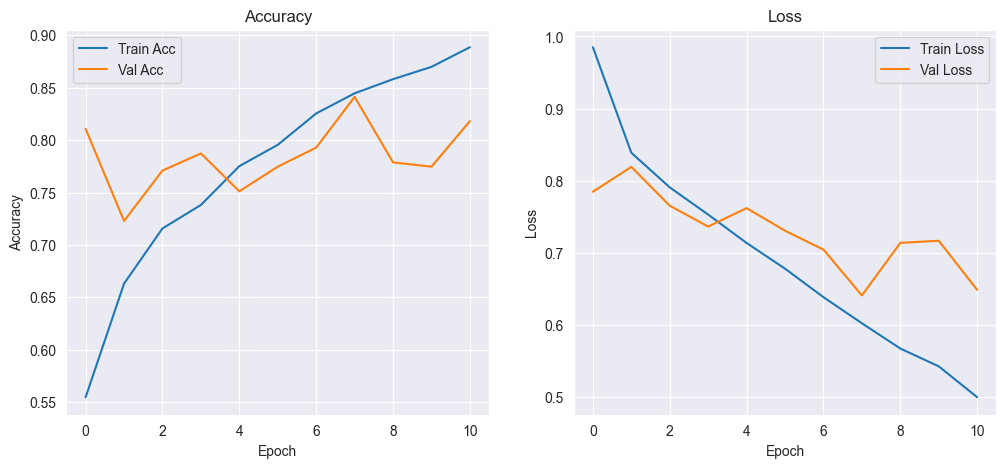

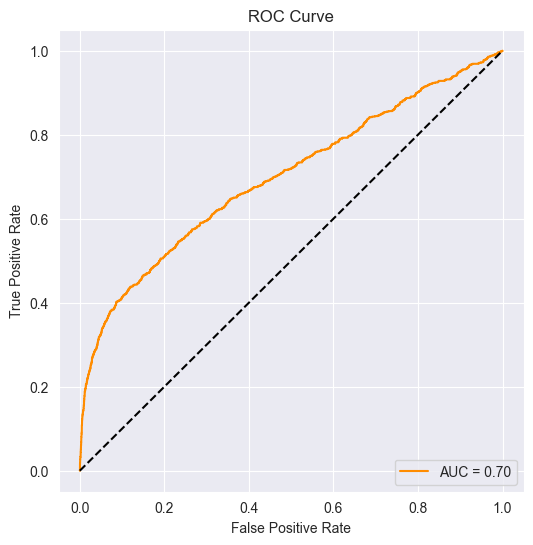

In [34]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()


1DCNN + LSTM + SMOTE

In [35]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Split into training and test sets (keep stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_ori, y_train_ori, test_size=0.2, shuffle=True, random_state=42, stratify=y_train_ori
)

In [36]:
from imblearn.over_sampling import SMOTE

# Reshape for SMOTE
X_res_flat = X_train.reshape(X_train.shape[0], -1)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_res_flat, y_train)

# Reshape back to (samples, 100, 5)
X_train = X_resampled.reshape(-1, 100, 8)
y_train = y_resampled

/Users/honyaozhi/PycharmProjects/aataembedding/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [37]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D, BatchNormalization

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(100, 8)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    LSTM(128),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compile with a slightly lower learning rate
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00025)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks — EarlyStopping and ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6
)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate on test set
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")


/Users/honyaozhi/PycharmProjects/aataembedding/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 98, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 98, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,865 (425.25 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.7536 - loss: 0.5235 - val_accuracy: 0.7890 - val_loss: 0.3920 - learning_rate: 2.5000e-04
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.8421 - loss: 0.3905 - val_accuracy: 0.8216 - val_loss: 0.3695 - learning_rate: 2.5000e-04
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.8610 - loss: 0.3551 - val_accuracy: 0.8595 - val_loss: 0.2751 - learning_rate: 2.5000e-04
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.8714 - loss: 0.3346 - val_accuracy: 0.9358 - val_loss: 0.1303 - learning_rate: 2.5000e-04
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.8907 - loss: 0.2847 - val_accuracy: 0.9405 - val_loss: 0.1202 - learning_rate: 2.5000e-04
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.9063 - loss: 0.2533 - val_accuracy: 0.9224 - val_loss: 0.1525 - learning_rate: 2.5000e-04
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

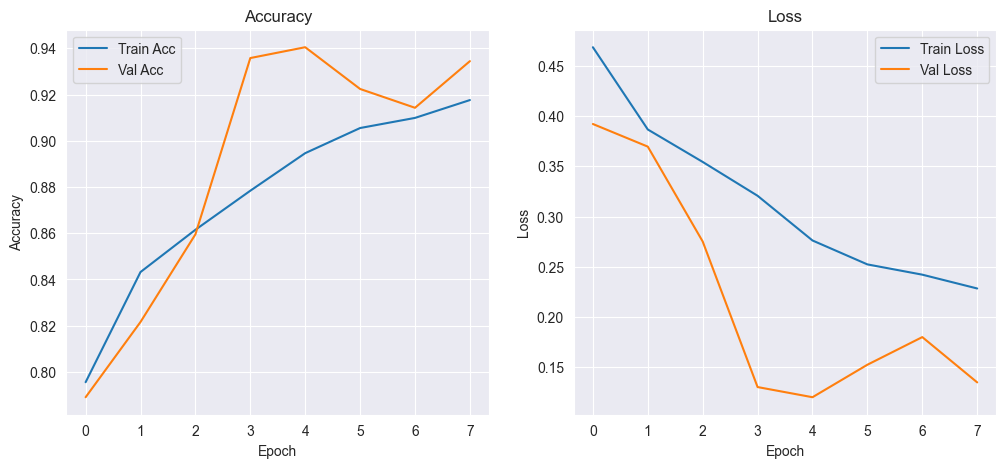

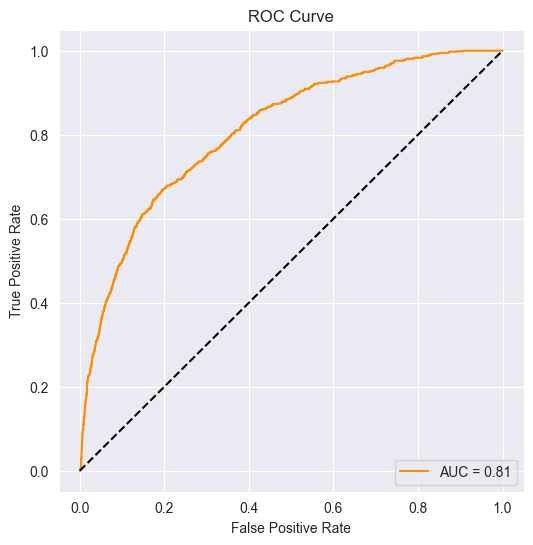

In [38]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()


Confusion Matrix (rows = true classes, columns = predicted classes):
[[5145  461]
 [ 455  380]]


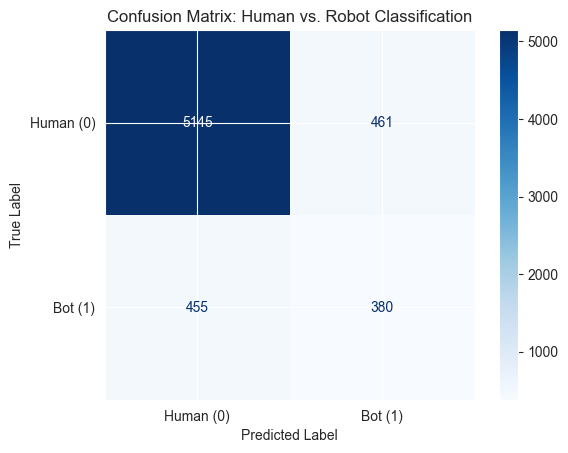

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

print("Confusion Matrix (rows = true classes, columns = predicted classes):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human (0)", "Bot (1)"])
disp.plot(cmap="Blues", xticks_rotation="horizontal")
plt.title("Confusion Matrix: Human vs. Robot Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [40]:
import joblib
joblib.dump(model, '1dcnn_best_model.pkl')

['1dcnn_best_model.pkl']